In [1]:
!pip install scikit-learn==1.3.2

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
rice_df = pd.read_excel('rice_word2vec_3mer_dataset.xlsx')

In [3]:
df_cold = rice_df.query('stress == "-" or stress == "cold"').replace('-', 0).replace('cold', 1)

<ipython-input-3-9bf9b2fbb131>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cold = rice_df.query('stress == "-" or stress == "cold"').replace('-', 0).replace('cold', 1)


### LGBM Cold Model

In [4]:
# Define X and y (target) variables
X = df_cold.drop(['circName','stress','tissue','chr','start','end','strand','start_anno'], axis=1)
y = df_cold['stress']

In [17]:
ros = RandomUnderSampler(sampling_strategy=0.7)

X_res, y_res = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=12)

In [18]:
model_lgb = lgb.LGBMClassifier(random_state=12)
model_lgb.fit(X_train, y_train)

y_pred = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

[LightGBM] [Info] Number of positive: 4526, number of negative: 6594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 11120, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.407014 -> initscore=-0.376322
[LightGBM] [Info] Start training from score -0.376322
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1583
           1       0.71      0.62      0.67      1198

    accuracy                           0.73      2781
   macro avg       0.73      0.72      0.72      2781
weighted avg       0.73      0.73      0.73      2781



In [19]:
print(model_lgb.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 12, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [20]:
dump(model_lgb, 'lgb_model_cold.joblib')
print('LGB - Cold Model created.')

LGB - Cold Model created.


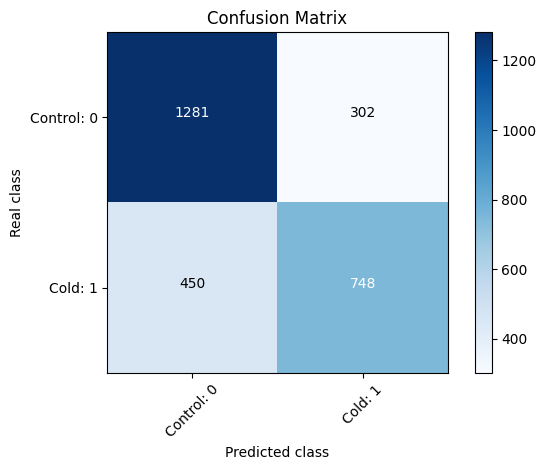

In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #plt.ylim(0.5, 0.5)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(1.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

plot_confusion_matrix(cnf_matrix, classes=['Control: 0', 'Cold: 1'])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
import numpy as np
y_prob = model_lgb.predict_proba(X_test)[:, 1]

# Testar vários thresholds
thresholds = np.arange(0.0, 1.1, 0.1)
results = []

for threshold in thresholds:
    y_pred_test = (y_prob >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    accuracy = accuracy_score(y_test, y_pred_test)

    results.append({
        'Threshold': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Acurácia': accuracy
    })

# Criar um DataFrame para visualizar os resultados
results_df = pd.DataFrame(results)
print(results_df)

    Threshold  Precision    Recall  F1 Score       AUC  Acurácia
0         0.0   0.430780  1.000000  0.602161  0.785579  0.430780
1         0.1   0.462331  0.973289  0.626882  0.785579  0.500899
2         0.2   0.533399  0.899833  0.669773  0.785579  0.617763
3         0.3   0.600489  0.820534  0.693474  0.785579  0.687522
4         0.4   0.659382  0.730384  0.693069  0.785579  0.721323
5         0.5   0.712381  0.624374  0.665480  0.785579  0.729594
6         0.6   0.765278  0.459933  0.574557  0.785579  0.706580
7         0.7   0.838269  0.307179  0.449603  0.785579  0.676016
8         0.8   0.849162  0.126878  0.220770  0.785579  0.614168
9         0.9   0.700000  0.005843  0.011589  0.785579  0.570658
10        1.0   0.000000  0.000000  0.000000  0.785579  0.569220
